In [4]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map

from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    ExpCutoffPowerLawSpectralModel,
    #PowerLawNuisanceSpectralModel,
    #PowerLawNormNuisanceSpectralModel
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys
sys.path.append('/home/katrin/Documents/nuisance_summary/E_reco/')

from Dataset_Creation import sys_dataset


In [5]:
figformat = 'svg'

In [6]:
import json
with open("/home/katrin/Documents/nuisance_summary/E_reco/config.json") as json_data_file:

    config = json.load(json_data_file)
config = config['local']
print(config)
source = 'Crab'
path = config["path"]
path_crab = config["path_crab"]


dataset_load = MapDataset.read(f'{path}/{source}/stacked.fits')
dataset_load = dataset_load.downsample(4)
models = Models.read(f"{path_crab}/standard_model.yml")
model_spectrum  = ExpCutoffPowerLawSpectralModel(
    index=2.3,
    amplitude="1e-12 TeV-1 cm-2 s-1",    
    lambda_ = "0.1 TeV-1")
source_model = SkyModel(spatial_model = models['main source'].spatial_model ,
                       spectral_model = model_spectrum,
                       name = "Source")    
models = Models(source_model)

bkg_model = FoVBackgroundModel(dataset_name=dataset_load.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)

dataset_load.models = models
dataset_load.counts = dataset_load.npred()

{'path': '/home/katrin/Documents', 'path_crab': '/home/katrin/Documents/Crab'}


In [7]:
biass = [-0.1, 0.0, 0.1]
bias_assumed = 0.1
sigmass = [0]


In [9]:
def create_dataset(b, s):
    sys_d_cor = sys_dataset(dataset_asimov= dataset_load,
                        shift = 0,
                        tilt = 0,
                        bias = b, 
                        sigma = s,
                        rnd = False,
                        e_reco_creation=10,
                        cutoff=True)
    dataset_conv = sys_d_cor.create_dataset()
    dataset_conv_N = sys_d_cor.create_dataset_N(1)
    dataset_conv_N.models.parameters['resolution'].frozen  = True
    dataset_conv_N.e_reco_n = 10
    
    # new fine binned IRF Model
    dataset_conv_N_fine =  sys_d_cor.create_dataset_N(10)

    zero = 1e-12
    penalising_invcovmatrix = np.zeros((2, 2))
    if b ==0 :
        b_ = zero
    else:
        b_ = b
    np.fill_diagonal(penalising_invcovmatrix, [1/bias_assumed**2, 1/zero**2])
    dataset_conv_N.penalising_invcovmatrix = penalising_invcovmatrix
    dataset_conv_N_fine.penalising_invcovmatrix = penalising_invcovmatrix
    
    return dataset_conv, dataset_conv_N, dataset_conv_N_fine

datasets_conv =[]
datasets_conv_N =[]
datasets_conv_N_fine = []

for b in biass:
    dataset_conv, dataset_conv_N , dataset_conv_N_fine = create_dataset(b, sigmass[0])
    datasets_conv.append(dataset_conv)
    datasets_conv_N.append(dataset_conv_N)
    datasets_conv_N_fine.append(dataset_conv_N_fine)
    
#datasets_conv = Datasets(datasets_conv)
#datasets_conv_N = Datasets(datasets_conv_N)
#datasets_conv_N_fine = Datasets(datasets_conv_N_fine)


in map: 0.0
evaluate: 0.0 -0.1
10
in map: 0.0
evaluate: 0.0 -0.1
10
in map: 0.0
evaluate: 0.0 -0.1
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.1
10
in map: 0.0
evaluate: 0.0 0.1
10
in map: 0.0
evaluate: 0.0 0.1
10


In [10]:
def sum_e (data):
    return data.sum(axis=2).sum(axis=1)

eaxis_standard = dataset_load.geoms['geom'].axes[0]

in map: 0.0
evaluate: 0.0 0.0
10


<WCSAxesSubplot: >

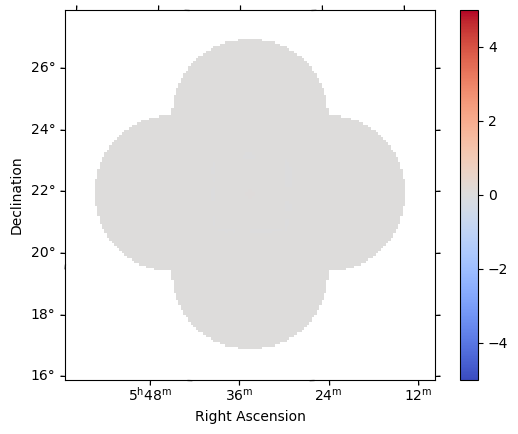

In [11]:
d = dataset_conv_N
d.plot_residuals_spatial()

In [16]:
energy = datasets_conv[0].counts.geom.axes[0].center.value
energy_bounds = (energy[0], energy[-1] ) * u.TeV
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10


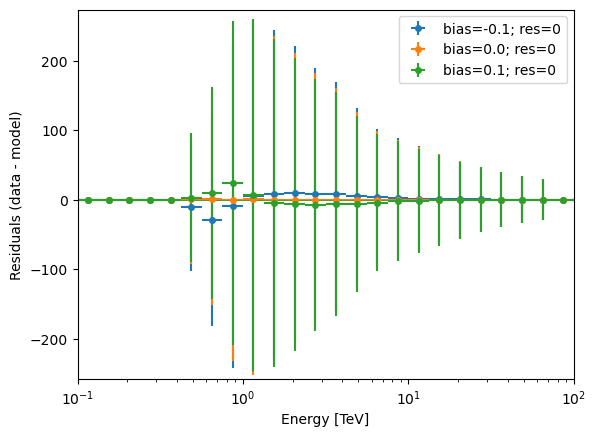

In [17]:
fig, ax = plt.subplots()
i = 0

for b in biass:
    for s in sigmass:
        d = datasets_conv_N[i]
        d.plot_residuals_spectral(ax =ax, color= colors[i], 
                    label = f"bias={b}; res={s}")
        #d = datasets_conv_N_fine[i]
        #d.plot_residuals_spectral(ax =ax, color= colors[1], 
        #            label = f"bias={b}; res={s}")
        i += 1
ax.legend()

fig.savefig(f"plots/2_Residual_pre_fit.svg")

in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10


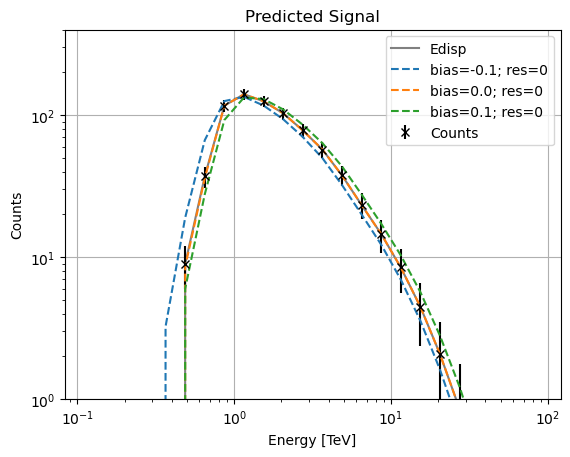

In [18]:
import matplotlib.pyplot as plt

# Your data processing code here

plt.title("Predicted Signal")
i = 0 
fmts = ['o', 'x', '--', ':']
colors = ['orange', 'red', 'tab:blue', 'green']
plt.plot(energy,sum_e(dataset_load.counts.data-dataset_load.background.data),
         label = "Edisp", color = 'grey')
npreds_pre_fit = []
npreds_pre_fit_N = []
npreds_pre_fit_N_fine = []
plt.errorbar(energy, sum_e(d.counts.data-d.background.data), 
             yerr = np.sqrt(sum_e(d.counts.data-d.background.data)),
            fmt = 'x', label = "Counts", color = 'black')

for b in biass:
    for s in sigmass:
        npreds_pre_fit.append( sum_e(datasets_conv[i].npred_signal().data))
        npreds_pre_fit_N.append( sum_e(datasets_conv_N[i].npred_signal().data))
        npreds_pre_fit_N_fine.append( sum_e(datasets_conv_N_fine[i].npred_signal().data))
        
        plt.plot( energy, sum_e(datasets_conv[i].npred_signal().data),
                 '--', label = f"bias={b}; res={s}",)# color = colors[i])
        #plt.plot( sum_e(datasets_conv_N[i].npred_signal().data),
        #         'x', label = f"bias={b}; res={s}", color = colors[i])
        #plt.plot( sum_e(datasets_conv_N_fine[i].npred_signal().data),
        #         '--', label = f"bias={b}; res={s}", color = colors[i])
        i += 1
        
plt.ylim(1e0, 4e2)
plt.loglog()
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.xlabel("Energy [TeV]")
plt.ylabel("Counts")
plt.grid(True)
fig = plt.gcf()
fig.savefig(f"plots/2_Npred.svg")


corr
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -7.525e+05                 │              Nfcn = 756              │
│ EDM = 0.00372 (Goal: 2e-06)      │            time = 8.1 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ ABOVE EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────────────┬───────────┬───────────┬────────────┬────────────┬────────

in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.

in map: 0.0
evaluate: 0.0 0.030682395115995575
10
in map: 0.0
evaluate: 0.0 0.030682395115995575
10
in map: 0.0
evaluate: 0.0 0.030682395115995575
10
in map: 0.0
evaluate: 0.0 0.030682395115995575
10
in map: 0.0
evaluate: 0.0 0.030682395115995575
10
in map: 0.0
evaluate: 0.0 0.030682395115995575
10
in map: 0.0
evaluate: 0.0 0.030682395115995575
10
in map: 0.0
evaluate: 0.0 0.030682395115995575
10
in map: 0.0
evaluate: 0.0 0.030682395115995575
10
in map: 0.0
evaluate: 0.0 0.030682395115995575
10
in map: 0.0
evaluate: 0.0 0.030682395115995575
10
in map: 0.0
evaluate: 0.0 0.030682395115995575
10
in map: 0.0
evaluate: 0.0 0.039154931926640636
10
in map: 0.0
evaluate: 0.0 0.022209858305350515
10
in map: 0.0
evaluate: 0.0 0.05124764385149988
10
in map: 0.0
evaluate: 0.0 0.010117146380491274
10
in map: 0.0
evaluate: 0.0 0.04707852302610967
10
in map: 0.0
evaluate: 0.0 0.014286267205881487
10
in map: 0.0
evaluate: 0.0 0.06280022254804413
10
in map: 0.0
evaluate: 0.0 -0.0014354323160529828
10
i

in map: 0.0
evaluate: 0.0 0.03391813667237269
10
in map: 0.0
evaluate: 0.0 0.03391813667237269
10
in map: 0.0
evaluate: 0.0 0.03391813667237269
10
in map: 0.0
evaluate: 0.0 0.03391813667237269
10
in map: 0.0
evaluate: 0.0 0.054513540278403196
10
in map: 0.0
evaluate: 0.0 0.03391813667237269
10
in map: 0.0
evaluate: 0.0 0.03391813667237269
10
in map: 0.0
evaluate: 0.0 0.03391813667237269
10
in map: 0.0
evaluate: 0.0 0.054513540278403196
10
in map: 0.0
evaluate: 0.0 0.03391813667237269
10
in map: 0.0
evaluate: 0.0 0.03391813667237269
10
in map: 0.0
evaluate: 0.0 0.054513540278403196
10
in map: 0.0
evaluate: 0.0 0.03391813667237269
10
in map: 0.0
evaluate: 0.0 0.054513540278403196
10
in map: 0.0
evaluate: 0.0 0.054513540278403196
10
in map: 0.0
evaluate: 0.0 0.015340311961055012
10
in map: 0.0
evaluate: 0.0 0.02793130918903557
10
in map: 0.0
evaluate: 0.0 0.02793130918903557
10
in map: 0.0
evaluate: 0.0 0.02793130918903557
10
in map: 0.0
evaluate: 0.0 0.02793130918903557
10
in map: 0.0
ev

in map: 0.0
evaluate: 0.0 0.02946605979792292
10
in map: 0.0
evaluate: 0.0 0.02946605979792292
10
in map: 0.0
evaluate: 0.0 0.02946605979792292
10
in map: 0.0
evaluate: 0.0 0.02946605979792292
10
in map: 0.0
evaluate: 0.0 0.02946605979792292
10
in map: 0.0
evaluate: 0.0 0.02946605979792292
10
in map: 0.0
evaluate: 0.0 0.02946605979792292
10
in map: 0.0
evaluate: 0.0 0.02946605979792292
10
in map: 0.0
evaluate: 0.0 0.03295557308456268
10
in map: 0.0
evaluate: 0.0 0.025976546511283168
10
in map: 0.0
evaluate: 0.0 0.03016396245525087
10
in map: 0.0
evaluate: 0.0 0.028768157140594972
10
in map: 0.0
evaluate: 0.0 0.029605640329388512
10
in map: 0.0
evaluate: 0.0 0.02932647926645733
10
in map: 0.0
evaluate: 0.0 0.02946605979792292
10
in map: 0.0
evaluate: 0.0 0.02946605979792292
10
in map: 0.0
evaluate: 0.0 0.02946605979792292
10
in map: 0.0
evaluate: 0.0 0.02946605979792292
10
in map: 0.0
evaluate: 0.0 0.02946605979792292
10
in map: 0.0
evaluate: 0.0 0.04691362623112169
10
in map: 0.0
evalu

in map: 0.0
evaluate: 0.0 0.04077193125681619
10
in map: 0.0
evaluate: 0.0 0.04077193125681619
10
in map: 0.0
evaluate: 0.0 0.04077193125681619
10
in map: 0.0
evaluate: 0.0 0.04077193125681619
10
in map: 0.0
evaluate: 0.0 0.04077193125681619
10
in map: 0.0
evaluate: 0.0 0.04077193125681619
10
in map: 0.0
evaluate: 0.0 0.04077193125681619
10
in map: 0.0
evaluate: 0.0 0.04077193125681619
10
in map: 0.0
evaluate: 0.0 0.04077193125681619
10
in map: 0.0
evaluate: 0.0 0.04077193125681619
10
in map: 0.0
evaluate: 0.0 0.04077193125681619
10
in map: 0.0
evaluate: 0.0 0.04077193125681619
10
in map: 0.0
evaluate: 0.0 0.04077193125681619
10
in map: 0.0
evaluate: 0.0 0.04077193125681619
10
in map: 0.0
evaluate: 0.0 0.04077193125681619
10
in map: 0.0
evaluate: 0.0 0.04077193125681619
10
in map: 0.0
evaluate: 0.0 0.04077193125681619
10
in map: 0.0
evaluate: 0.0 0.04077193125681619
10
in map: 0.0
evaluate: 0.0 0.04077193125681619
10
in map: 0.0
evaluate: 0.0 0.04077193125681619
10
in map: 0.0
evaluate

in map: 0.0
evaluate: 0.0 0.045694221472646325
10
in map: 0.0
evaluate: 0.0 0.036436134709028616
10
in map: 0.0
evaluate: 0.0 0.04646907747740436
10
in map: 0.0
evaluate: 0.0 0.035661278704270584
10
in map: 0.0
evaluate: 0.0 0.04735509220497664
10
in map: 0.0
evaluate: 0.0 0.0347752639766983
10
in map: 0.0
evaluate: 0.0 0.048357902811246245
10
in map: 0.0
evaluate: 0.0 0.033772453370428696
10
in map: 0.0
evaluate: 0.0 0.041091727562369285
10
in map: 0.0
evaluate: 0.0 0.0410796835835713
10
in map: 0.0
evaluate: 0.0 0.04108472717955648
10
in map: 0.0
evaluate: 0.0 0.04108472717955648
10
in map: 0.0
evaluate: 0.0 0.04108472717955648
10
in map: 0.0
evaluate: 0.0 0.04108472717955648
10
in map: 0.0
evaluate: 0.0 0.04108472717955648
10
in map: 0.0
evaluate: 0.0 0.04108472717955648
10
in map: 0.0
evaluate: 0.0 0.04108472717955648
10
in map: 0.0
evaluate: 0.0 0.04108472717955648
10
in map: 0.0
evaluate: 0.0 0.04108472717955648
10
in map: 0.0
evaluate: 0.0 0.04108472717955648
10
in map: 0.0
eval

in map: 0.0
evaluate: 0.0 0.041316328055340856
10
in map: 0.0
evaluate: 0.0 0.041316328055340856
10
in map: 0.0
evaluate: 0.0 0.041316328055340856
10
in map: 0.0
evaluate: 0.0 0.041316328055340856
10
in map: 0.0
evaluate: 0.0 0.041316328055340856
10
in map: 0.0
evaluate: 0.0 0.05971766642819652
10
in map: 0.0
evaluate: 0.0 0.022914989682485194
10
in map: 0.0
evaluate: 0.0 0.041346861472478645
10
in map: 0.0
evaluate: 0.0 0.041468995141029814
10
in map: 0.0
evaluate: 0.0 0.04149356147035749
10
in map: 0.0
evaluate: 0.0 0.04149356147035749
10
in map: 0.0
evaluate: 0.0 0.04149356147035749
10
in map: 0.0
evaluate: 0.0 0.04149356147035749
10
in map: 0.0
evaluate: 0.0 0.04149356147035749
10
in map: 0.0
evaluate: 0.0 0.04149356147035749
10
in map: 0.0
evaluate: 0.0 0.04149356147035749
10
in map: 0.0
evaluate: 0.0 0.04149356147035749
10
in map: 0.0
evaluate: 0.0 0.04149356147035749
10
in map: 0.0
evaluate: 0.0 0.04149356147035749
10
in map: 0.0
evaluate: 0.0 0.04149356147035749
10
in map: 0.0


in map: 0.0
evaluate: 0.0 0.04149359465992054
10
in map: 0.0
evaluate: 0.0 0.04149356427845182
10
in map: 0.0
evaluate: 0.0 0.04149356107954188
10
in map: 0.0
evaluate: 0.0 0.04149356107954188
10
in map: 0.0
evaluate: 0.0 0.04149356107954188
10
in map: 0.0
evaluate: 0.0 0.04149356107954188
10
in map: 0.0
evaluate: 0.0 0.04149356107954188
10
in map: 0.0
evaluate: 0.0 0.04149356107954188
10
in map: 0.0
evaluate: 0.0 0.04149356107954188
10
in map: 0.0
evaluate: 0.0 0.04149356107954188
10
in map: 0.0
evaluate: 0.0 0.04149356107954188
10
in map: 0.0
evaluate: 0.0 0.04149356107954188
10
in map: 0.0
evaluate: 0.0 0.04149356107954188
10
in map: 0.0
evaluate: 0.0 0.04149356107954188
10
in map: 0.0
evaluate: 0.0 0.04149356107954188
10
in map: 0.0
evaluate: 0.0 0.061436772392520905
10
in map: 0.0
evaluate: 0.0 0.021550349766562855
10
in map: 0.0
evaluate: 0.0 0.04149356107954188
10
in map: 0.0
evaluate: 0.0 0.04149356107954188
10
in map: 0.0
evaluate: 0.0 0.04149356107954188
10
in map: 0.0
evalua

in map: 0.0
evaluate: 0.0 0.04147926342678325
10
in map: 0.0
evaluate: 0.0 0.04147926342678325
10
in map: 0.0
evaluate: 0.0 0.04147926342678325
10
in map: 0.0
evaluate: 0.0 0.04147926342678325
10
in map: 0.0
evaluate: 0.0 0.04147926342678325
10
in map: 0.0
evaluate: 0.0 0.04147926342678325
10
in map: 0.0
evaluate: 0.0 0.04147926342678325
10
in map: 0.0
evaluate: 0.0 0.04147926342678325
10
in map: 0.0
evaluate: 0.0 0.04147926342678325
10
in map: 0.0
evaluate: 0.0 0.04147926342678325
10
in map: 0.0
evaluate: 0.0 0.04147926342678325
10
in map: 0.0
evaluate: 0.0 0.04147926342678325
10
in map: 0.0
evaluate: 0.0 0.04147926342678325
10
in map: 0.0
evaluate: 0.0 0.04147926342678325
10
in map: 0.0
evaluate: 0.0 0.04147926342678325
10
in map: 0.0
evaluate: 0.0 0.04147926342678325
10
in map: 0.0
evaluate: 0.0 0.04147926342678325
10
in map: 0.0
evaluate: 0.0 0.04147926342678325
10
in map: 0.0
evaluate: 0.0 0.04147926342678325
10
in map: 0.0
evaluate: 0.0 0.04147926342678325
10
in map: 0.0
evaluate

in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.042356605695435104
10
in map: 0.0
evaluate: 0.0 -0.042356605695435104
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 

in map: 0.0
evaluate: 0.0 -0.011235049042482643
10
in map: 0.0
evaluate: 0.0 0.043384957955226386
10
in map: 0.0
evaluate: 0.0 -0.04132825291707719
10
in map: 0.0
evaluate: 0.0 0.01718943864798797
10
in map: 0.0
evaluate: 0.0 -0.015132733609838772
10
in map: 0.0
evaluate: 0.0 0.005766878940593393
10
in map: 0.0
evaluate: 0.0 0.0025776526806888635
10
in map: 0.0
evaluate: 0.0 0.001696152398619082
10
in map: 0.0
evaluate: 0.0 0.0013452651080051792
10
in map: 0.0
evaluate: 0.0 0.0011851036486391498
10
in map: 0.0
evaluate: 0.0 0.0011423071625206796
10
in map: 0.0
evaluate: 0.0 0.0011423071625206796
10
in map: 0.0
evaluate: 0.0 0.0011423071625206796
10
in map: 0.0
evaluate: 0.0 0.0011423071625206796
10
in map: 0.0
evaluate: 0.0 0.0011423071625206796
10
in map: 0.0
evaluate: 0.0 0.0011423071625206796
10
in map: 0.0
evaluate: 0.0 0.0011423071625206796
10
in map: 0.0
evaluate: 0.0 0.0011423071625206796
10
in map: 0.0
evaluate: 0.0 0.0011423071625206796
10
in map: 0.0
evaluate: 0.0 0.001142307

in map: 0.0
evaluate: 0.0 0.0011423071625206796
10
in map: 0.0
evaluate: 0.0 0.0011423071625206796
10
in map: 0.0
evaluate: 0.0 0.0011423071625206796
10
in map: 0.0
evaluate: 0.0 0.0011423071625206796
10
in map: 0.0
evaluate: 0.0 0.0011423071625206796
10
in map: 0.0
evaluate: 0.0 0.0011423071625206796
10
in map: 0.0
evaluate: 0.0 0.0011423071625206796
10
in map: 0.0
evaluate: 0.0 0.016032877088835124
10
in map: 0.0
evaluate: 0.0 -0.013748262763793765
10
in map: 0.0
evaluate: 0.0 0.0011423071625206796
10
in map: 0.0
evaluate: 0.0 0.0011423071625206796
10
in map: 0.0
evaluate: 0.0 0.0011423071625206796
10
in map: 0.0
evaluate: 0.0 0.0011423071625206796
10
in map: 0.0
evaluate: 0.0 0.0011423071625206796
10
in map: 0.0
evaluate: 0.0 0.0011423071625206796
10
in map: 0.0
evaluate: 0.0 0.0011423071625206796
10
in map: 0.0
evaluate: 0.0 0.0011423071625206796
10
in map: 0.0
evaluate: 0.0 0.0011423071625206796
10
in map: 0.0
evaluate: 0.0 0.0011423071625206796
10
in map: 0.0
evaluate: 0.0 0.0011

in map: 0.0
evaluate: 0.0 0.0011423071625206796
10
in map: 0.0
evaluate: 0.0 0.0011423071625206796
10
in map: 0.0
evaluate: 0.0 0.043498912476534854
10
in map: 0.0
evaluate: 0.0 0.0011423071625206796
10
in map: 0.0
evaluate: 0.0 0.0011423071625206796
10
in map: 0.0
evaluate: 0.0 0.0011423071625206796
10
in map: 0.0
evaluate: 0.0 0.043498912476534854
10
in map: 0.0
evaluate: 0.0 0.0011423071625206796
10
in map: 0.0
evaluate: 0.0 0.0011423071625206796
10
in map: 0.0
evaluate: 0.0 0.043498912476534854
10
in map: 0.0
evaluate: 0.0 0.0011423071625206796
10
in map: 0.0
evaluate: 0.0 0.043498912476534854
10
in map: 0.0
evaluate: 0.0 0.043498912476534854
10
in map: 0.0
evaluate: 0.0 0.0011423071625206796
10
in map: 0.0
evaluate: 0.0 0.0011423071625206796
10
in map: 0.0
evaluate: 0.0 0.0011423071625206796
10
in map: 0.0
evaluate: 0.0 0.0011423071625206796
10
in map: 0.0
evaluate: 0.0 0.0011423071625206796
10
in map: 0.0
evaluate: 0.0 0.0011423071625206796
10
in map: 0.0
evaluate: 0.0 0.00114230

in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.0
evaluate: 0.0 0.0
10
in map: 0.

in map: 0.0
evaluate: 0.0 -0.03967380941797159
10
in map: 0.0
evaluate: 0.0 -0.023213233950591664
10
in map: 0.0
evaluate: 0.0 -0.022453966277954648
10
in map: 0.0
evaluate: 0.0 -0.022385940524480917
10
in map: 0.0
evaluate: 0.0 -0.02236414665598745
10
in map: 0.0
evaluate: 0.0 -0.022355070121198615
10
in map: 0.0
evaluate: 0.0 -0.022350888274943657
10
in map: 0.0
evaluate: 0.0 -0.02234887200548242
10
in map: 0.0
evaluate: 0.0 -0.022347879228749108
10
in map: 0.0
evaluate: 0.0 -0.022347879228749108
10
in map: 0.0
evaluate: 0.0 -0.022347879228749108
10
in map: 0.0
evaluate: 0.0 -0.022347879228749108
10
in map: 0.0
evaluate: 0.0 -0.022347879228749108
10
in map: 0.0
evaluate: 0.0 -0.022347879228749108
10
in map: 0.0
evaluate: 0.0 -0.022347879228749108
10
in map: 0.0
evaluate: 0.0 -0.022347879228749108
10
in map: 0.0
evaluate: 0.0 -0.022347879228749108
10
in map: 0.0
evaluate: 0.0 -0.022347879228749108
10
in map: 0.0
evaluate: 0.0 -0.022347879228749108
10
in map: 0.0
evaluate: 0.0 -0.02234

in map: 0.0
evaluate: 0.0 -0.02231765367184833
10
in map: 0.0
evaluate: 0.0 -0.02231765367184833
10
in map: 0.0
evaluate: 0.0 -0.010010159258819254
10
in map: 0.0
evaluate: 0.0 -0.034625148084877405
10
in map: 0.0
evaluate: 0.0 -0.02231765367184833
10
in map: 0.0
evaluate: 0.0 -0.02231765367184833
10
in map: 0.0
evaluate: 0.0 -0.02231765367184833
10
in map: 0.0
evaluate: 0.0 -0.02231765367184833
10
in map: 0.0
evaluate: 0.0 -0.02231765367184833
10
in map: 0.0
evaluate: 0.0 -0.02231765367184833
10
in map: 0.0
evaluate: 0.0 -0.02231765367184833
10
in map: 0.0
evaluate: 0.0 -0.02231765367184833
10
in map: 0.0
evaluate: 0.0 -0.02231765367184833
10
in map: 0.0
evaluate: 0.0 -0.02231765367184833
10
in map: 0.0
evaluate: 0.0 -0.02231765367184833
10
in map: 0.0
evaluate: 0.0 -0.02231765367184833
10
in map: 0.0
evaluate: 0.0 -0.02231765367184833
10
in map: 0.0
evaluate: 0.0 -0.02231765367184833
10
in map: 0.0
evaluate: 0.0 -0.02231765367184833
10
in map: 0.0
evaluate: 0.0 -0.02231765367184833
1

in map: 0.0
evaluate: 0.0 -0.02231765367184833
10
in map: 0.0
evaluate: 0.0 -0.02231765367184833
10
in map: 0.0
evaluate: 0.0 -0.02231765367184833
10
in map: 0.0
evaluate: 0.0 -0.02231765367184833
10
in map: 0.0
evaluate: 0.0 -0.02231765367184833
10
in map: 0.0
evaluate: 0.0 -0.02231765367184833
10
in map: 0.0
evaluate: 0.0 -0.02231765367184833
10
in map: 0.0
evaluate: 0.0 -0.02231765367184833
10
in map: 0.0
evaluate: 0.0 -0.02231765367184833
10
in map: 0.0
evaluate: 0.0 -0.02231765367184833
10
in map: 0.0
evaluate: 0.0 -0.02231765367184833
10
in map: 0.0
evaluate: 0.0 -0.02231765367184833
10
in map: 0.0
evaluate: 0.0 -0.02231765367184833
10
in map: 0.0
evaluate: 0.0 -0.02231765367184833
10
in map: 0.0
evaluate: 0.0 0.0002864891053497576
10
in map: 0.0
evaluate: 0.0 -0.04492179644904642
10
in map: 0.0
evaluate: 0.0 -0.006881762399101061
10
in map: 0.0
evaluate: 0.0 -0.037753544944595596
10
in map: 0.0
evaluate: 0.0 -0.03241041957427809
10
in map: 0.0
evaluate: 0.0 -0.024478961733398717

in map: 0.0
evaluate: 0.0 -0.02231765367184833
10
in map: 0.0
evaluate: 0.0 -0.02231765367184833
10
in map: 0.0
evaluate: 0.0 -0.02231765367184833
10
in map: 0.0
evaluate: 0.0 -0.02231765367184833
10
in map: 0.0
evaluate: 0.0 -0.02231765367184833
10
in map: 0.0
evaluate: 0.0 -0.02231765367184833
10
in map: 0.0
evaluate: 0.0 -0.019060994753738698
10
in map: 0.0
evaluate: 0.0 -0.025574312589957963
10
in map: 0.0
evaluate: 0.0 -0.021666321888226404
10
in map: 0.0
evaluate: 0.0 -0.022968985455470256
10
in map: 0.0
evaluate: 0.0 -0.02231765367184833
10
in map: 0.0
evaluate: 0.0 -0.02231765367184833
10
in map: 0.0
evaluate: 0.0 -0.02231765367184833
10
in map: 0.0
evaluate: 0.0 -0.02231765367184833
10
in map: 0.0
evaluate: 0.0 -0.02231765367184833
10
in map: 0.0
evaluate: 0.0 -0.006034359081300171
10
in map: 0.0
evaluate: 0.0 -0.02231765367184833
10
in map: 0.0
evaluate: 0.0 -0.02231765367184833
10
in map: 0.0
evaluate: 0.0 -0.02231765367184833
10
in map: 0.0
evaluate: 0.0 -0.0223176536718483

'\n    for d in datasets_conv_N_fine:\n    fit_cor_N_fine = Fit(store_trace=True)\n    fit_cor_N_fine.optimize_opts = {"tol": 0.001, "strategy": 2}\n    result_cor_N_fine = fit_cor_N_fine.run(d)\n    d.models.covariance = fit_cor_N_fine.covariance(d).matrix\n    d.models.covariance.plot_correlation()\n    print(fit_cor_N_fine.minuit)\n   '

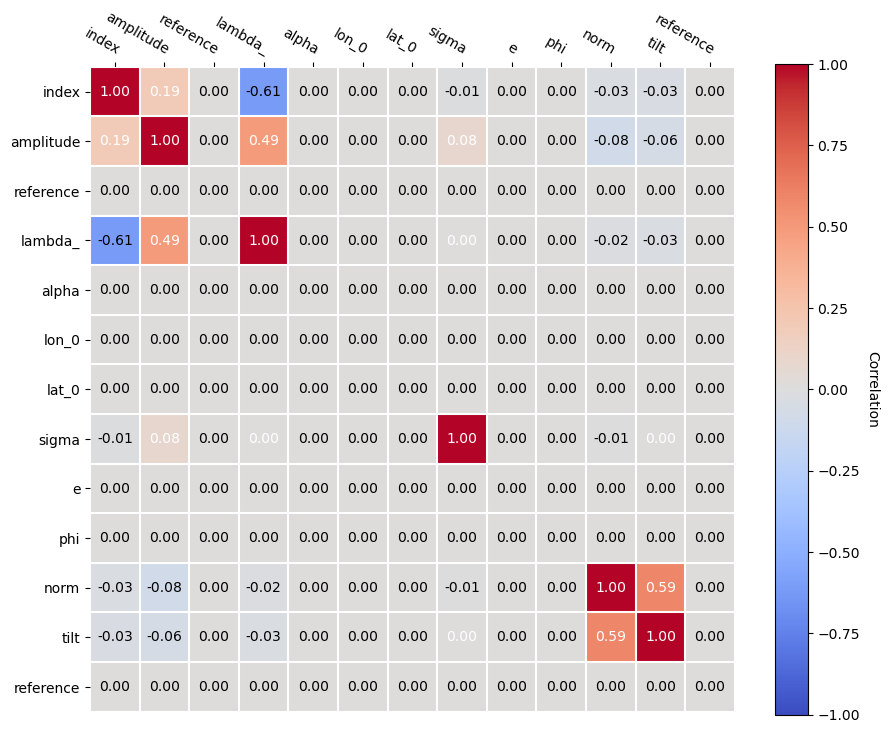

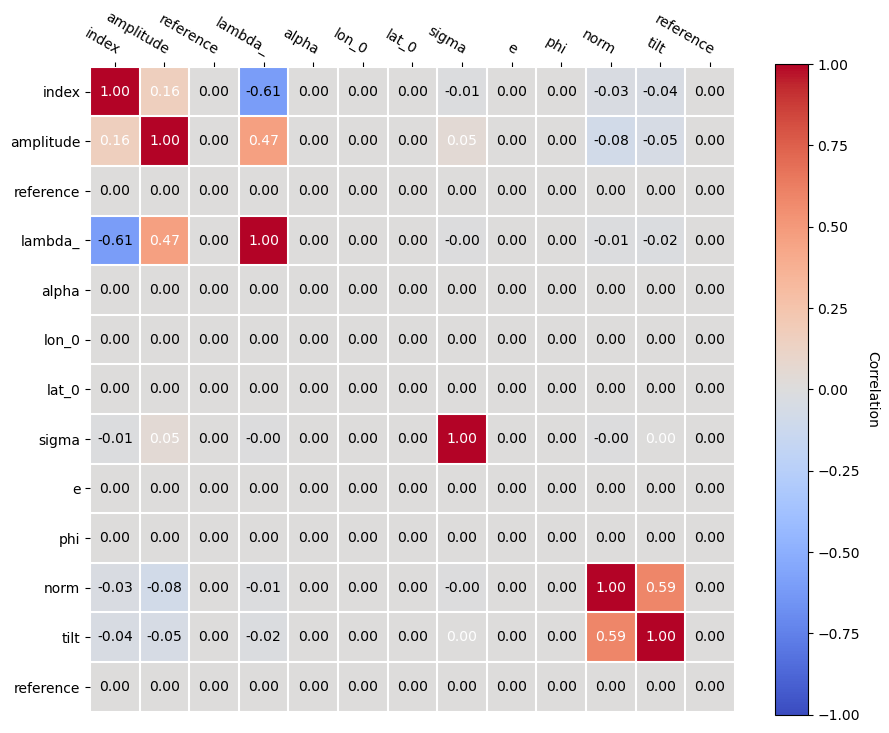

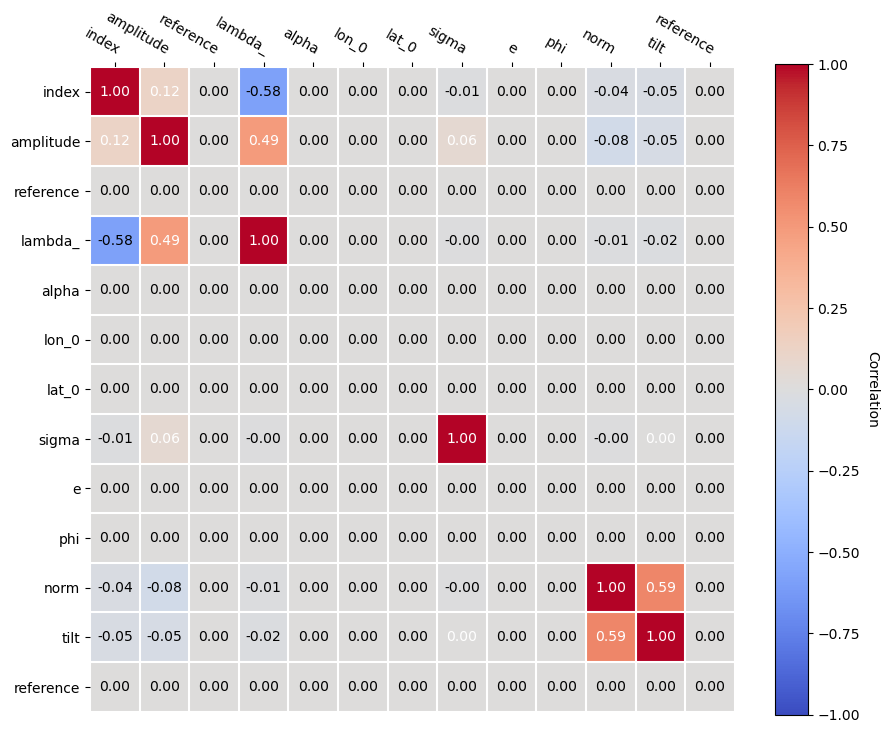

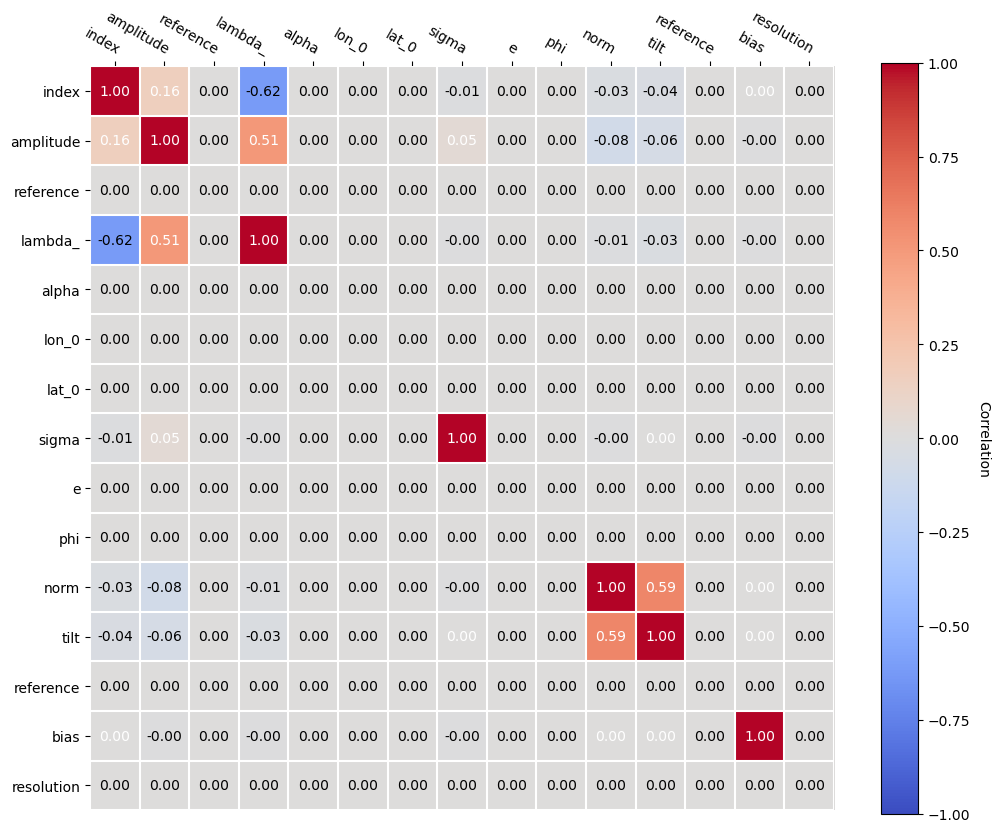

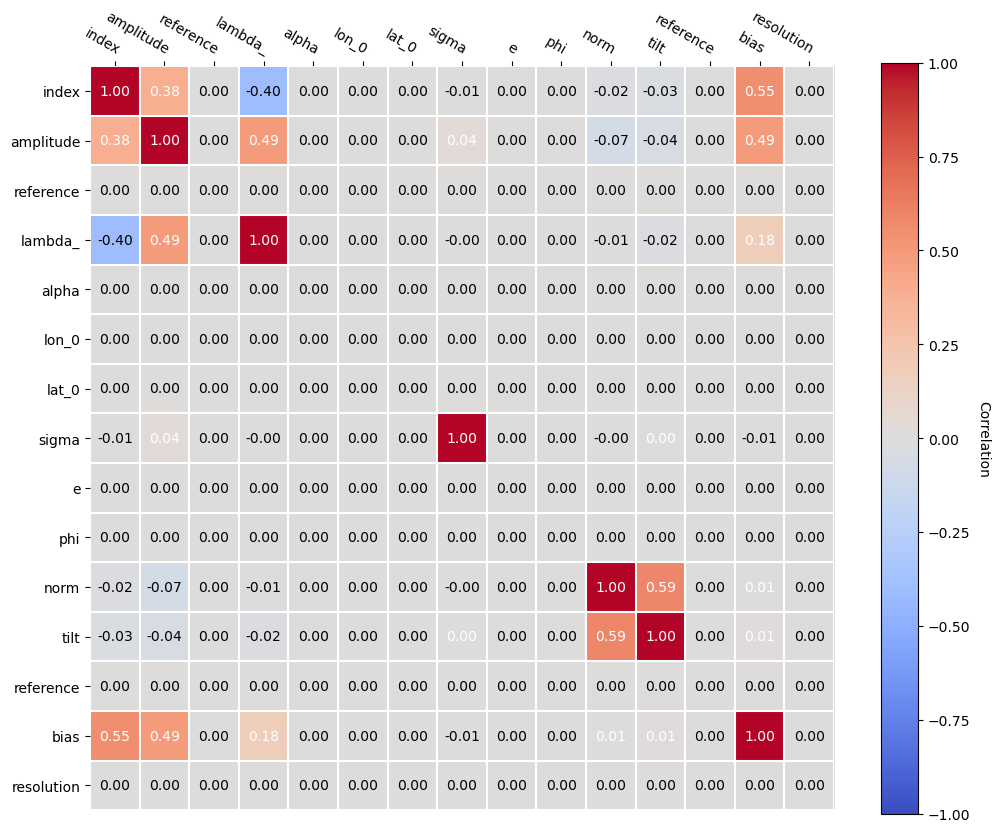

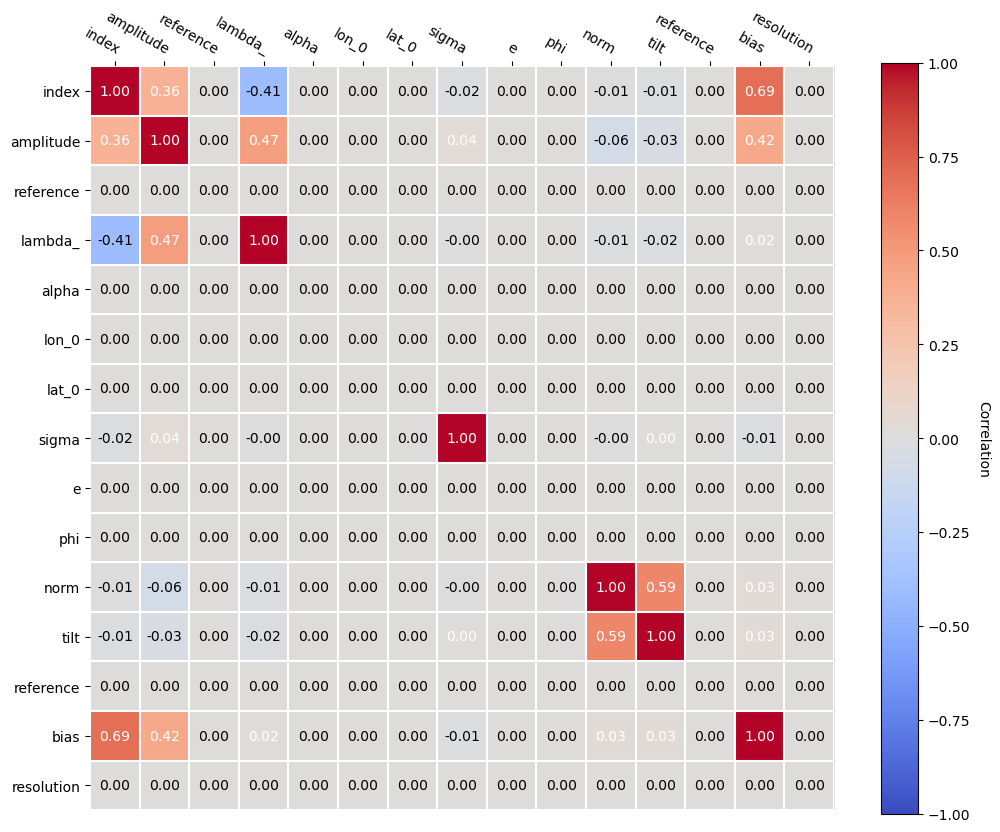

In [19]:
%%time
print("corr")
for d in datasets_conv:

    fit_cor = Fit(store_trace=True)
    minuit_opts = {"tol": 0.001, "strategy": 2}
    fit_cor.optimize_opts = minuit_opts
    result_cor = fit_cor.run(d)
    d.models.covariance = fit_cor.covariance(d).matrix
    d.models.covariance.plot_correlation()
    print(fit_cor.minuit)
    
for d in datasets_conv_N:
    fit_cor_N = Fit(store_trace=True)
    fit_cor_N.optimize_opts = {"tol": 0.001, "strategy": 2}
    result_cor_N = fit_cor_N.run(d)
    d.models.covariance = fit_cor_N.covariance(d).matrix
    d.models.covariance.plot_correlation()
    print(fit_cor_N.minuit)

'''
    for d in datasets_conv_N_fine:
    fit_cor_N_fine = Fit(store_trace=True)
    fit_cor_N_fine.optimize_opts = {"tol": 0.001, "strategy": 2}
    result_cor_N_fine = fit_cor_N_fine.run(d)
    d.models.covariance = fit_cor_N_fine.covariance(d).matrix
    d.models.covariance.plot_correlation()
    print(fit_cor_N_fine.minuit)
   '''

In [20]:
colors_standard = ['darkmagenta', 'darkred', 'darkolivegreen', 'darkred']
colors_nui = ['cornflowerblue', 'navy', 'darkolivegreen', 'darkred']
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_standard = 'darkmagenta'; color_nui = 'cornflowerblue'
color_standard_ = 'darkred'; color_nui_ = 'navy'

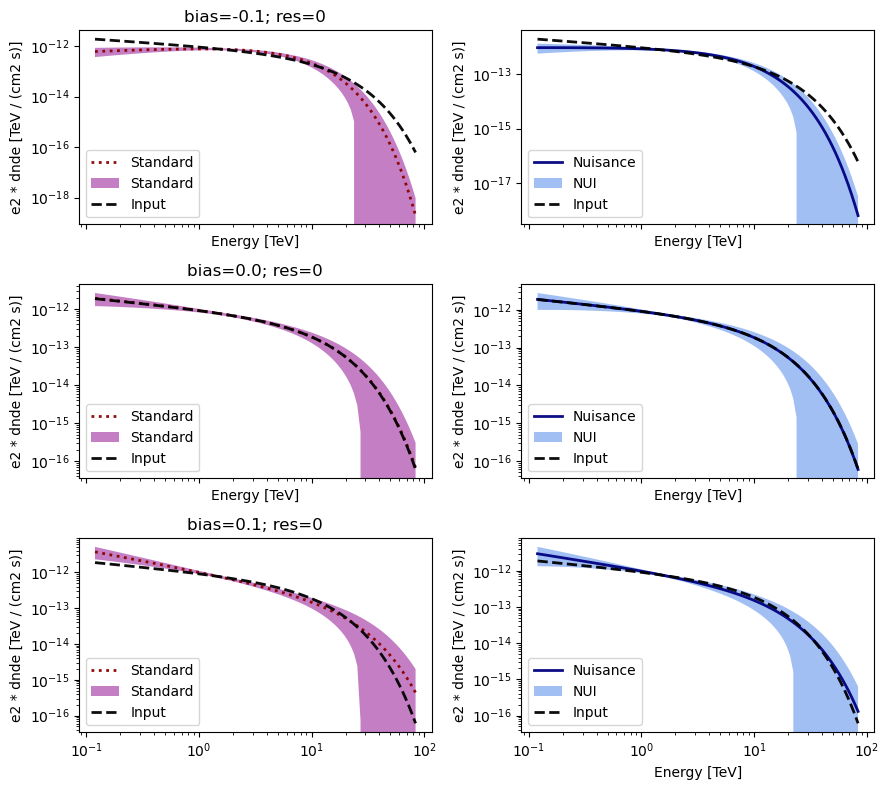

In [33]:


fig,axss = plt.subplots(len(biass),2, sharex = True, sharey=False, figsize = (9,8
                                                                   ))
#axs = [axs]
i =0; ii =0
for b in biass:
    for s in sigmass:
        ii = 0
        axs = axss[i]
        d = datasets_conv_N[i]
        d.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[ii+1],
                                                               color=colors_nui[ii+1],
                                                                 label= f"Nuisance",
                                                                alpha = 0.95,
                                                               linestyle='-', linewidth= 2)       

        d.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[ii+1],
                                                               facecolor=colors_nui[ii],
                                                                 label="NUI",
                                                                alpha = 0.6)
        d = datasets_conv[i]
        d.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[ii],
                                                               color=colors_standard[ii+1],
                                                                 label= f"Standard",
                                                                alpha = 0.95,
                                                               linestyle=':', linewidth= 2)       

        d.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[ii],
                                                               facecolor=colors_standard[ii],
                                                                 label="Standard",
                                                                alpha = 0.5)
        '''d = datasets_conv_N_fine[i]
        d.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[ii+2],
                                                               color=colors[ii+1],
                                                                 label= f"fine Nui",
                                                                alpha = 0.95,
                                                               linestyle=':', linewidth= 2)       

        d.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[ii+2],
                                                               facecolor=colors[ii+1],
                                                                 label="fine Nui",
                                                                alpha = 0.5)'''
        
        axs[0].set_title(f"bias={b}; res={s}")
        i +=1
        ii +=1
for ass in axss:
    for a in ass:
        dataset_load.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = a,
                                                               color='black',
                                                                 label="Input",
                                                                alpha = 0.95,
                                                               linestyle='dashed', linewidth= 2)  
        a.legend()
    
ylim = axs[0].get_ylim()
axs[0].set_xlabel('')
plt.tight_layout()
fig.savefig(f"plots/2_Best_fit_Spectrum.svg")


in map: 0.0
evaluate: 0.0 0.04147926342678325
10
in map: 0.0
evaluate: 0.0 0.0011423071625206796
10
in map: 0.0
evaluate: 0.0 -0.02231765367184833
10


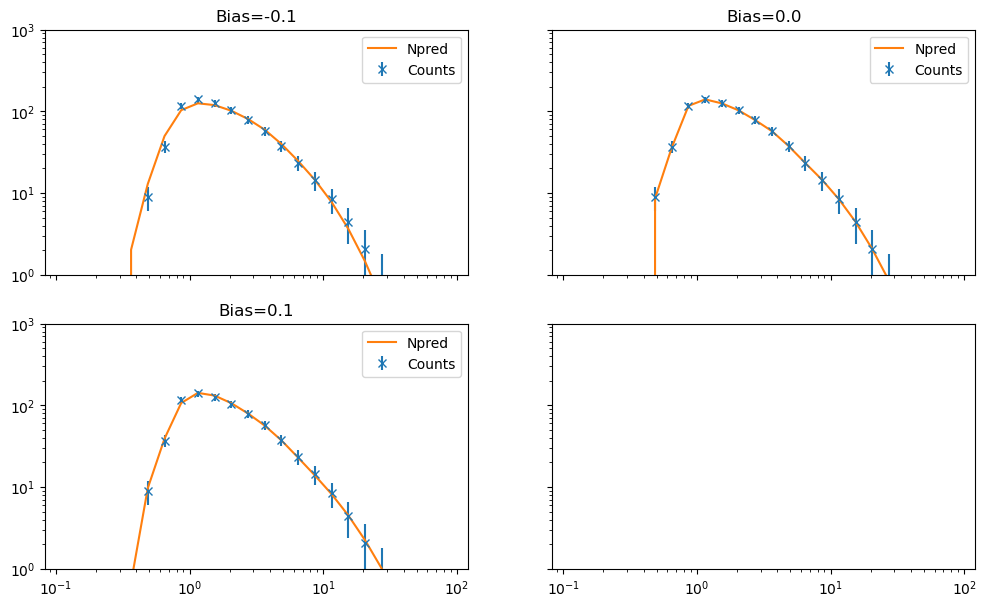

In [22]:
fig,axs = plt.subplots(2,2, sharex = True, sharey=True, figsize = (12,7))
axs = axs.flatten()
i =0; ii =0
for b in biass:
    for s in sigmass:
        d = datasets_conv_N[ii]
        axs[ii].errorbar(energy, sum_e(d.counts.data-d.background.data), 
                     yerr = np.sqrt(sum_e(d.counts.data-d.background.data)),
                    fmt = 'x', label = "Counts")

        axs[ii].plot(energy, sum_e(d.npred_signal().data), label = "Npred")
        axs[ii].loglog()
        axs[ii].legend()
        axs[ii].set_title(f"Bias={b}")
        axs[ii].set_ylim(1e0, 1e3)        
        ii +=1
        


in map: 0.0
evaluate: 0.0 0.04147926342678325
10
in map: 0.0
evaluate: 0.0 0.0011423071625206796
10
in map: 0.0
evaluate: 0.0 -0.02231765367184833
10


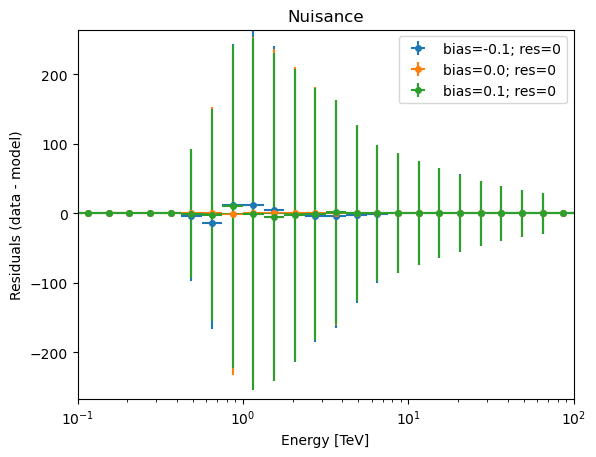

In [23]:
fig, ax = plt.subplots()
i = 0
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for b in biass:
    for s in sigmass:
        d = datasets_conv_N[i]
        d.plot_residuals_spectral(ax =ax, color= colors[i], 
                    label = f"bias={b}; res={s}")
        i += 1
ax.legend()
plt.title("Nuisance")

fig.savefig(f"plots/2_Residual_post_fit.svg")

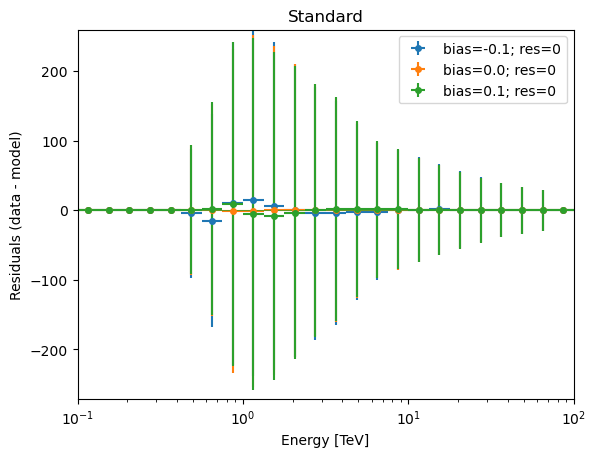

In [24]:
fig, ax = plt.subplots()
i = 0
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for b in biass:
    for s in sigmass:
        d = datasets_conv[i]
        d.plot_residuals_spectral(ax =ax, color= colors[i], 
                    label = f"bias={b}; res={s}")
        i += 1
ax.legend()
plt.title("Standard")
fig.savefig(f"plots/2_Residual_post_fit_standard.svg")

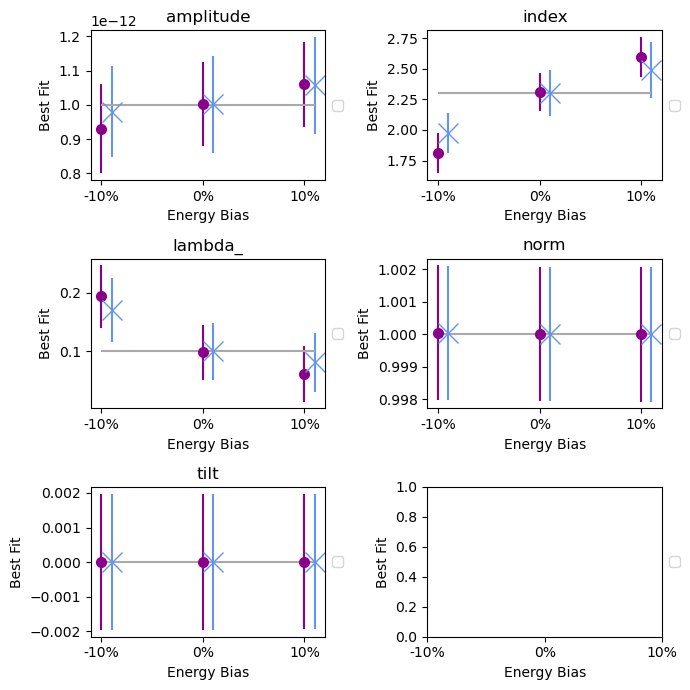

In [31]:
fig, axs = plt.subplots(3,2, figsize= (7, 7))
ax = axs.flatten()


parnames = ['amplitude', 'index', 'lambda_', 'norm', 'tilt', ]
ii =0;
for b in biass:
    for s in sigmass:
        d = datasets_conv[ii]
        for i, p in enumerate(parnames):
            value = d.models.parameters[p].value
            error = d.models.parameters[p].error    
            ax[i].errorbar(ii, value, yerr = error, fmt = 'o', color = color_standard,markersize = 7,
                          label = f'Standard')
        
        d = datasets_conv_N[ii]
        for i, p in enumerate(parnames):
            value = d.models.parameters[p].value
            error = d.models.parameters[p].error    
            ax[i].errorbar((ii+0.1), value, yerr = error, fmt = 'x', color = color_nui,markersize=14,
                          label ="Nuisance")
            
        ii +=1
labels_sys = [ '-10%', '0%', '10%']
for i, p in enumerate(parnames):
    value = dataset_load.models.parameters[p].value
    error = dataset_load.models.parameters[p].error    
    #ax[i].errorbar(4, value, yerr = error, fmt = 'x')
    ax[i].hlines( value, 0, len(labels_sys)-1+0.1, label = "input", color= 'darkgrey')
    ax[i].set_title(p)
    
    
for ax in ax:
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), ncol = 1, 
            loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_ylabel('Best Fit'); 
    ax.set_xlabel('Energy Bias'); 
    ax.set_xticks(np.arange(len(labels_sys)),labels_sys)
    
plt.tight_layout()
fig.savefig(f"plots/2_Best_fit_parameters.svg")
    

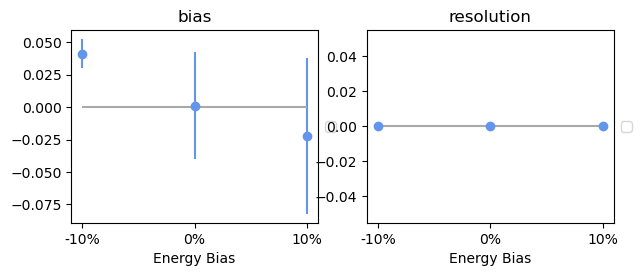

In [30]:
fig,ax  = plt.subplots(1,2,figsize= (7, 2.5))
ax = ax.flatten()
parnames = ['bias', 'resolution',]
labels_sys = []

ii =0;
for b in biass:
    for s in sigmass:
        d = datasets_conv_N[ii]
        for i, p in enumerate(parnames):
            value = d.models.parameters[p].value
            error = d.models.parameters[p].error    
            ax[i].errorbar(ii, value, yerr = error, fmt = 'o', color = color_nui)
            ax[i].set_title(p)
            
        labels_sys.append(f'B={b};\n R={s};')
            
            
        ii +=1
        
labels_sys = [ '-10%', '0%', '10%']
for i, p in enumerate(parnames):
    value = 0
    #ax[i].errorbar(4, value, yerr = error, fmt = 'x')
    ax[i].hlines( value, 0, len(labels_sys)-1,  color= 'darkgrey')
    ax[i].set_title(p)
    
    
for ax in ax:
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), ncol = 1, 
            loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel('Energy Bias'); 
    ax.set_xticks(np.arange(len(labels_sys)),labels_sys)
fig.savefig(f"plots/2_Best_fit_nui_parameters.svg")
    